# packaged-up fast implementations

In [1]:
import lbc.fit
import lbc.peaks
import lbc.util

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
image = lbc.util.load_image("sdR-r1-00362435.fit.gz")
image = lbc.util.flatten_image(image)

peak-finding from `fast-peak-finding.ipynb` has been implemented in `lbc.peaks`.

In [3]:
t0 = datetime.now()
peaks = lbc.peaks.detect_peaks(image)
peaks = peaks[:, [1, 0]]
t1 = datetime.now()
print((t1 - t0) / timedelta(milliseconds=1), 'ms')

1843.369 ms


model-fitting from `fast-fitting.ipynb` has been implemented in `lbc.fit`. there's a quick function with all the defaults:

fitting:   0%|          | 0/100 [00:00<?, ?epoch/s]

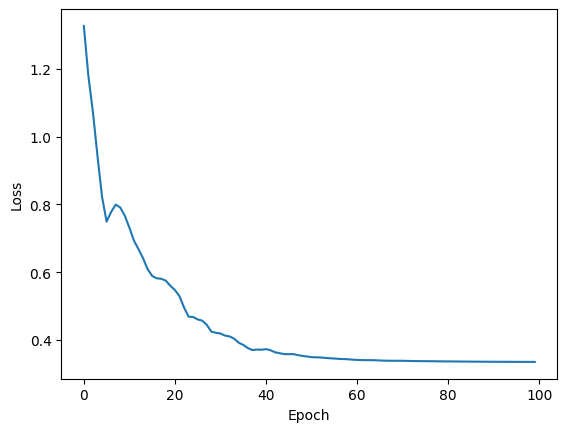

In [4]:
theta, losses = lbc.fit.fit_image(image, peaks, alpha=0.0, sigma=5, Q=10)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

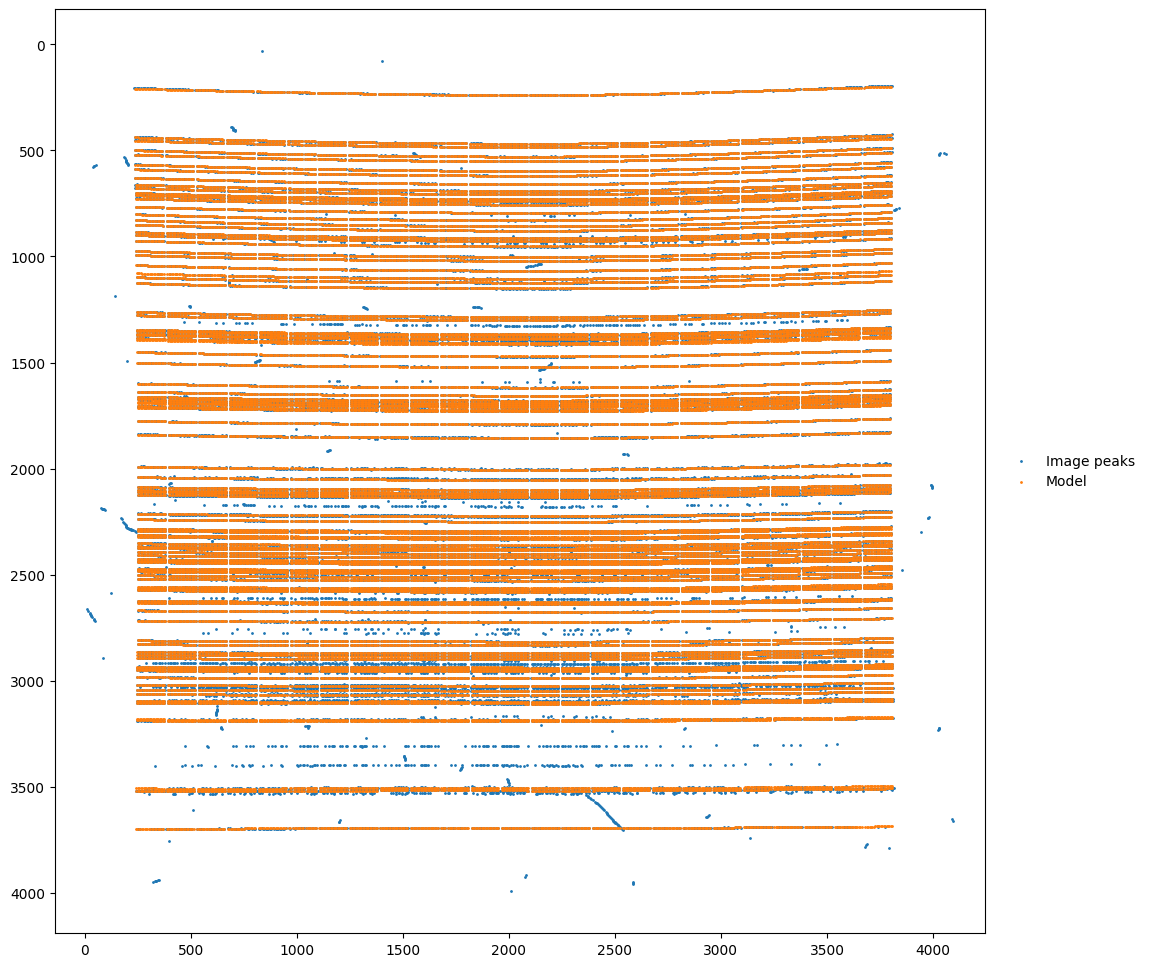

In [5]:
distorted = lbc.fit.distort(*theta)

plt.figure(figsize=(12, 12))
plt.scatter(*peaks.T, s=1, label='Image peaks')
plt.scatter(*distorted.T, s=1, label='Model')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.xlim(-0.5, 4096-0.5)
plt.ylim(4096-0.5, -0.5)
plt.axis('equal')
plt.show()

or there are function factories to manually implement the training loop for more control

fitting:   0%|          | 0/100 [00:00<?, ?epoch/s]

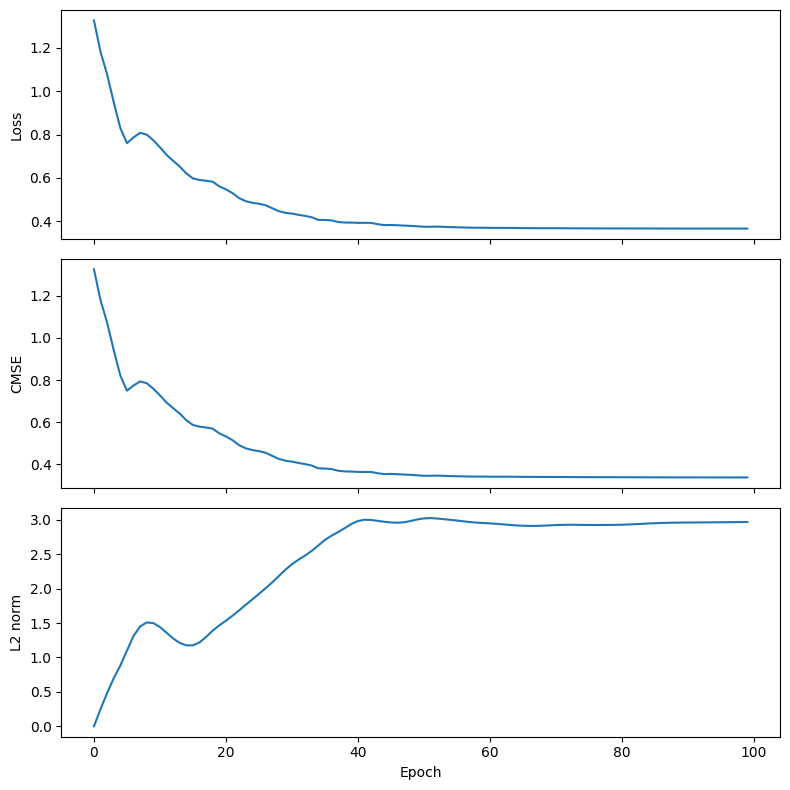

In [6]:
import jax
import jax.numpy as jnp
import optax
from tqdm.auto import tqdm

alpha = 0.01
sigma = 5.
Q = 10.

tree, idx = lbc.fit.find_neighbors(lbc.fit.distort, peaks)
deltas = lbc.fit.deltas_factory(peaks, idx)
capped_mse = lbc.fit.capped_mse_factory(deltas, peaks, idx, sigma=sigma, Q=Q)
forward = lbc.fit.forward_factory(lbc.fit.distort, capped_mse, alpha=alpha)
forward_grad = jax.value_and_grad(forward)

def lr_schedule(epoch: int):
    lr_0, lr_1 = 5e-1, 5e-2
    ep_0, ep_1 = 25, 100

    if epoch < ep_0:
        return lr_0
    if epoch < ep_1:
        t = (epoch - ep_0) / (ep_1 - ep_0)
        return lr_0 * (1 - t) + lr_1 * t
    return lr_1

theta = jnp.zeros((2, len(lbc.fit.INDICES)))
opt = optax.adam(learning_rate=lr_schedule)
opt_state = opt.init(theta)

losses = []

for _ in tqdm(range(100), desc='fitting', unit='epoch'):
    loss_val, grads = forward_grad(theta)
    cmse = capped_mse(lbc.fit.distort(*theta))
    l2 = lbc.fit.l2_regularization(theta)

    if jnp.isnan(loss_val).any() or jnp.isnan(grads).any():
        raise RuntimeError("NaN encountered, stopping early")

    updates, opt_state = opt.update(grads, opt_state)
    theta = optax.apply_updates(theta, updates)

    losses.append((loss_val, cmse, l2))


fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i, _l in enumerate(zip(*losses)):
    axs[i].plot(_l)
axs[0].set_ylabel('Loss')
axs[1].set_ylabel('CMSE')
axs[2].set_ylabel('L2 norm')
axs[-1].set_xlabel('Epoch')
fig.tight_layout()
plt.show()

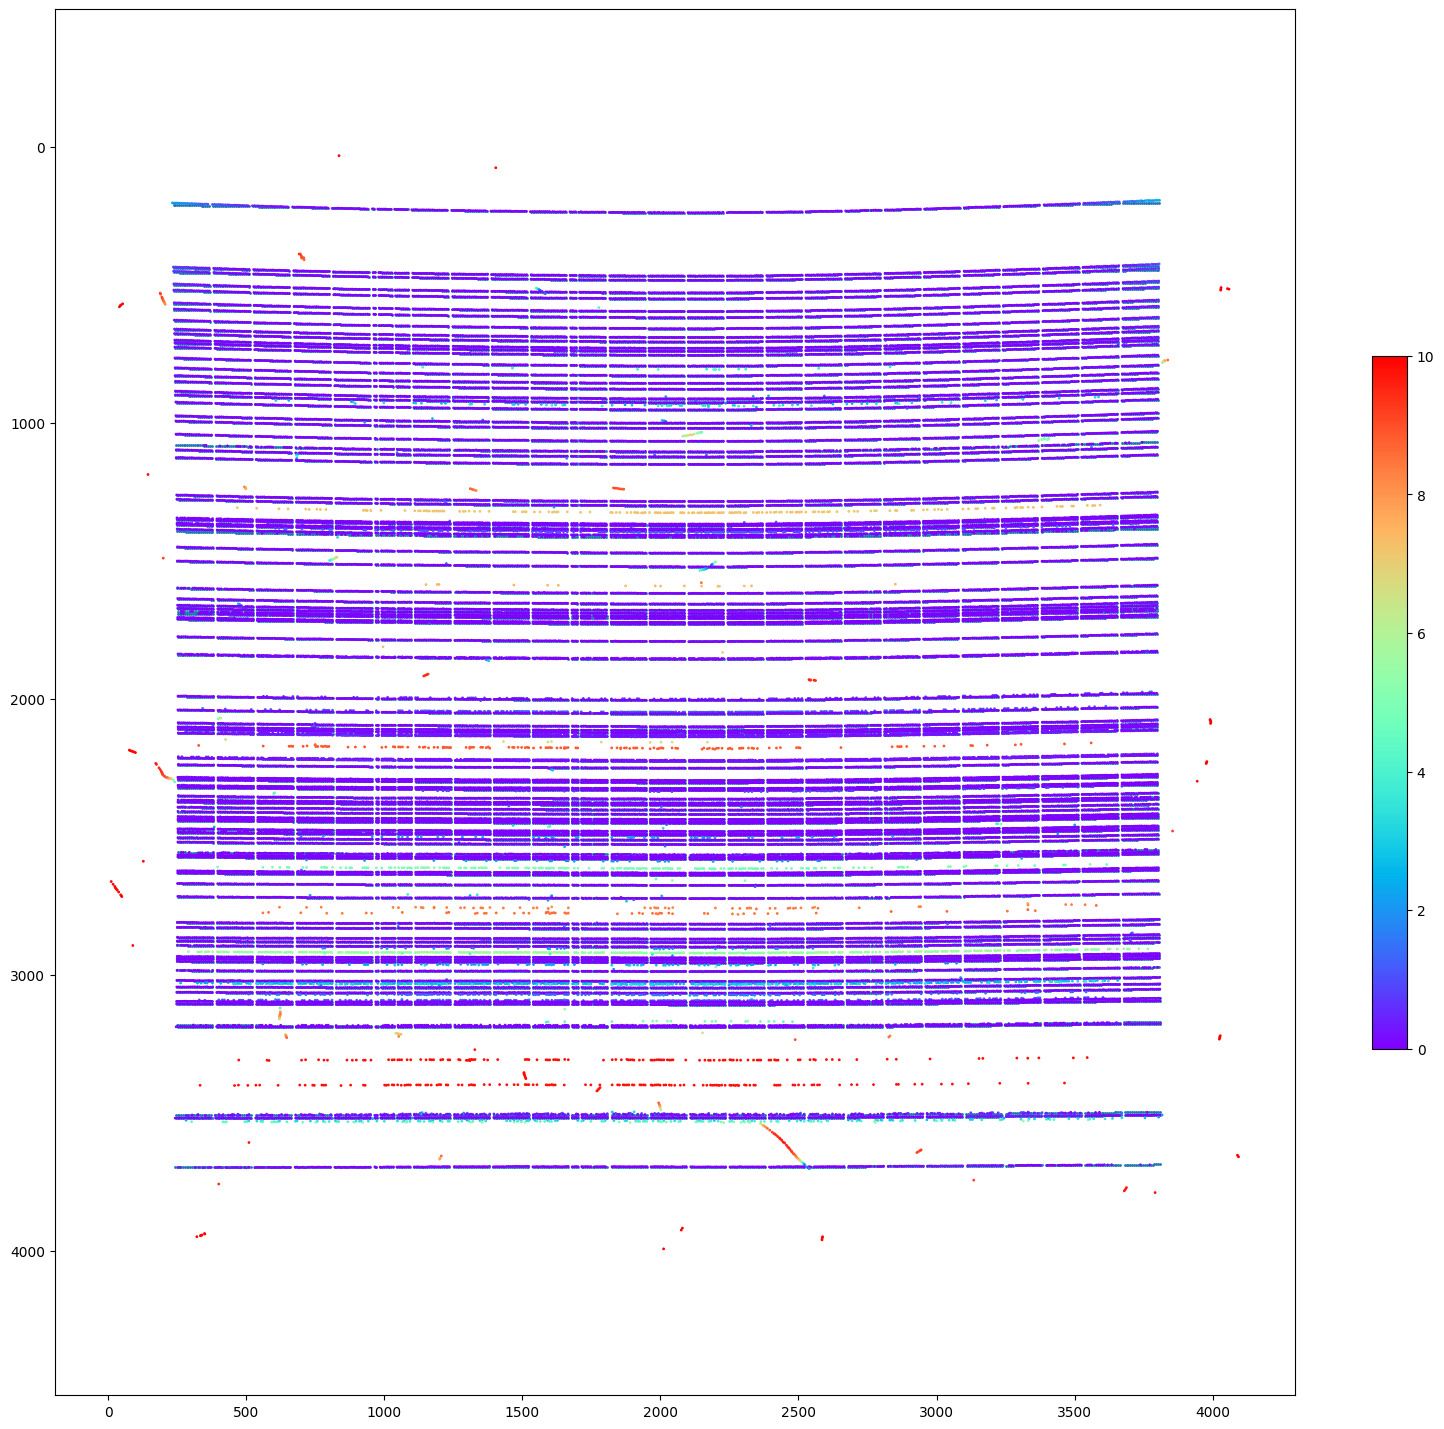

In [9]:
distorted = lbc.fit.distort(*theta)
ds = deltas(distorted)
c = 1 / (sigma**2 / ds + 1 / Q)

plt.figure(figsize=(20, 18))
plt.scatter(*distorted.T, s=1, label='Model')
plt.scatter(*peaks.T, s=1, c=c, cmap='rainbow', vmin=0, vmax=Q, label='Image peaks')
plt.colorbar(shrink=0.5)
plt.xlim(-0.5, 4096-0.5)
plt.ylim(4096-0.5, -0.5)
plt.axis('equal')
plt.show()